In [1]:
"""
Created By    : Christian M Nairy
Creation Date : 31 October 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.

We utilize the Cressman analysis (successive corrections) and perform
reverse Cressman analysis for three different iterations (passes) using
three different radii of influences (RoI). For the observations outside 
our grid we use bi-linear interpolation to account for those observations.
This script will plot 3 different plots:

1st plot: is the first pass which utilizes an RoI = 4 * dmin, where dmin is
is the average distance between the nearest rawinsondes in the data set.

2nd plot: is the second pass which utilizes an RoI = 2.5 * dmin.

3rd plot: is the third and final pass which utilizes an RoI = 1.5 * dmin.

This script then produces three more plots which shows the differences in
the height fields between the three passes (Pass2 - Pass1; Pass3 - Pass1;
Pass3 - Pass2)

Furthermore, this script performs and Root Mean Sqaure difference calculation
of those differences as decribed above.

Finally, this script outputs the Analysis Matrix datasets for each pass as well
as the Analysis Matrix differences and the RMS(D) of the Analysis Matrix differences
into individual text files.

"""
__author__    = "Christian M Nairy"
__contact__   = "christian.nairy@und.edu"

In [177]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [178]:
### Known Input Values ###
#These variables are either defined in our homework PDF or in our class notes
xnot = 18.9
ynot = -6.3
delx = 1.27
dely = 1.27
ro = 6371 * 1e5
lambdanot = -115
phinot = 60 * (np.pi/180)
m = 1/15000000

In [179]:
### Create function for Cressman Analysis ###
def cressman(d_ik, ROI):
    if d_ik <= ROI:
        w = ((ROI**2 - d_ik**2)/(ROI**2 + d_ik**2))
    elif d_ik > ROI:
        w = 0
    return w

In [180]:
### Read in observations ###
obs = np.loadtxt('RAOBs_201903131200.txt', dtype='str', delimiter=',')

#Make the observations their own data array
obs[:,[1,2,3,4,5]].astype(float) #All obs
ID = obs[:,0] #Station ID
lat_txt = obs[:,1].astype(float) #Latitude
lon_txt = obs[:,2].astype(float) #Longitude
height = obs[:,3].astype(float) #Heights
wind_dir = obs[:,4].astype(float) #Wind Direction
wind_speed = obs[:,5].astype(float) #Wind Speed

In [181]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x_step = xnot + np.arange(22)*delx #Calculate x - grid (JUST X - 1D)
y_step = ynot + np.arange(28)*dely #Calculate y - grid (JUST Y - 1D)

#Utilize meshgrid to return coordinate matricies from coordinate vectors (produced just above this line)
gridx, gridy = np.meshgrid(x_step,y_step) #Coordinate matricies defined as gridx and gridy

In [182]:
### convert obs lat/long to x,y ###
#convert lat and lon to radians
lat_rad = lat_txt * (np.pi/180)
lon_rad = lon_txt * (np.pi/180)

#Calculate sigma - equation is in our notes
sigma = ((1 + np.sin(phinot))/(1 + np.sin(lat_rad)))

#calculate lambda and convert to radians
lambda_rad = (lon_txt) * (np.pi/180)
lambdanot_rad = lambdanot * (np.pi/180)

#calculate r, x, and y on an image plane - equations are in our class notes
r = sigma * ro * np.cos(lat_rad) * m
x_plane = r * np.cos(lambda_rad - lambdanot_rad)
y_plane = r * np.sin(lambda_rad - lambdanot_rad)

#lon = np.arctan(gridy/gridx) * (180/np.pi) + lambdanot
#lat = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((gridx/m)**2) + (gridy/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))

#lon_ob = np.arctan(y_plane/x_plane) * (180/np.pi) + lambdanot
#lat_ob = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((x_plane/m)**2) + (y_plane/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))


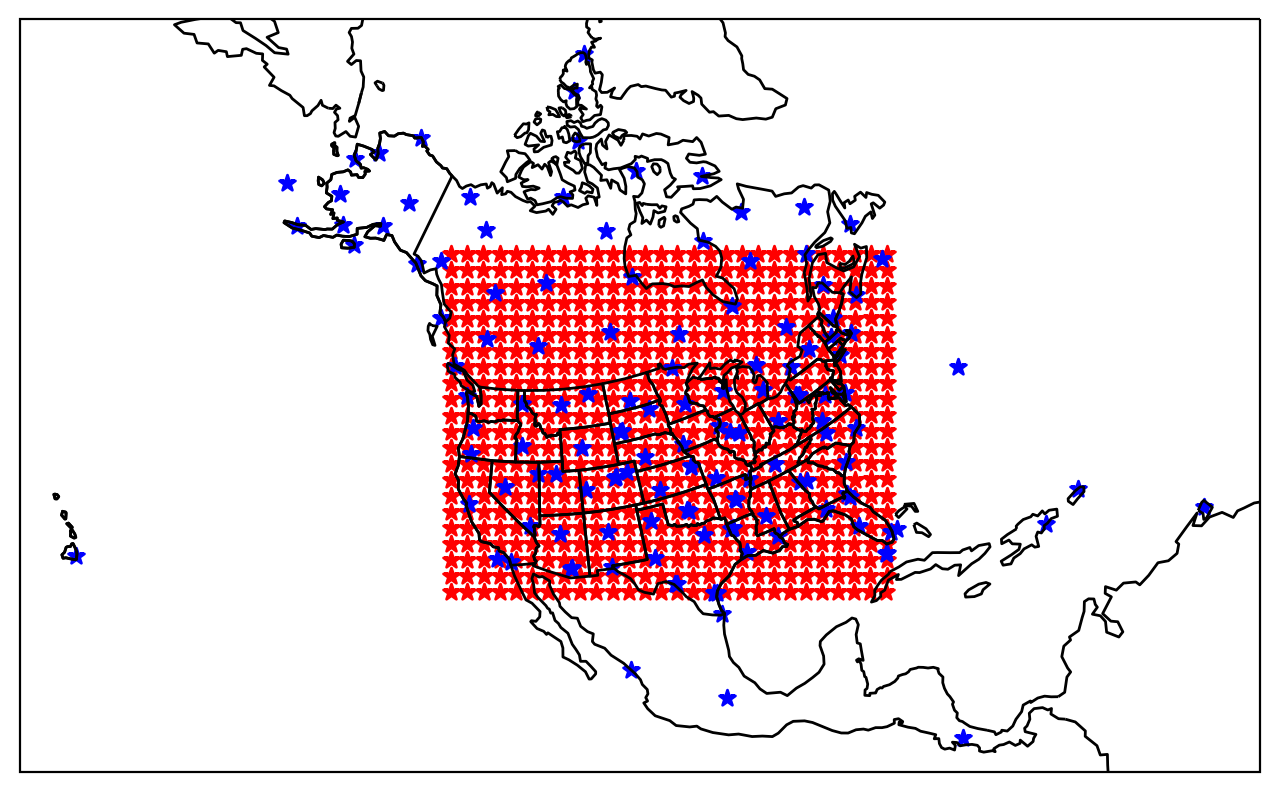

In [183]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
lon = np.arctan(gridy/gridx) * (180/np.pi) + lambdanot
lat = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((gridx/m)**2) + (gridy/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))

lon_ob = np.arctan(y_plane/x_plane) * (180/np.pi) + lambdanot
lat_ob = (180/np.pi) * ((np.pi/2) - (2 * np.arctan(((((x_plane/m)**2) + (y_plane/m)**2)**(1/2))/(ro * (1 + np.sin(phinot))))))


### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60) #our projection
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(lon.ravel(), lat.ravel(), c='r', marker='*', transform = ccrs.PlateCarree())
ax1.scatter(lon_ob.ravel(), lat_ob.ravel(), c='b', marker='*', transform = ccrs.PlateCarree())
plt.show()

In [184]:
### Find Dmin ###
dmin_empt = np.zeros(len(x_plane))
for i in range(135):
    r = ((x_plane[i] - x_plane)**2 + (y_plane[i] - y_plane)**2)**(1/2)
    r.sort()
    dmin_empt[i] = r[1]
    
dmin = np.mean(dmin_empt) 


In [185]:
## Calculate radius of influnces using dmin ###
ROI1 = 4*dmin
ROI2 = 2.5*dmin
ROI3 = 1.5*dmin

ROIs = np.array((ROI1, ROI2, ROI3)) #insert ROIs in array

y_n = 22
x_n = 28
#define empty analysis matrix
Analysis_mat = np.empty((x_n, y_n, len(ROIs)))

In [186]:
#First Pass
for x in range(len(gridx)): #go through each x-grid point (should be 0-27 [28 total])
    for y in range(len(gridx[0])): #go through each x-grid point by in the y-dir (should be 22 total points)
        rel_x = gridx[x,y] - x_plane #relative x distance
        rel_y = gridy[x,y] - y_plane #relative y distance
        radius = (rel_x**2 + rel_y**2)**(1/2) #calculate your radius from each grid point
        index_roi = np.where(radius <= ROIs[0]) #calc where your radius is less than or equal to your RoI
            
        #weights
        weights = np.zeros(len(x_plane))
        for j in index_roi[0]:
            w = cressman(radius[j],ROIs[0]) #perform the cressman algorithm as defined above
            weights[j] = w
        Analysis_mat[x,y,0] = np.sum(weights * height) / np.sum(weights)
            
            

In [187]:
### Create function for bilinear interpolation ###
def bilinear_interp(x, y, ROI):
    rel_x = x - int(np.floor(x))
    rel_y = y - int(np.floor(y))
    
    z_1 = Analysis_mat[int(np.floor(y)), int(np.floor(x)), ROI]
    z_2 = Analysis_mat[int(np.ceil(y)), int(np.floor(x)), ROI]
    z_3 = Analysis_mat[int(np.ceil(y)), int(np.ceil(x)), ROI]
    z_4 = Analysis_mat[int(np.floor(y)), int(np.ceil(x)), ROI]
    
    P = (((rel_x - 1)*(rel_y - 1)*z_1) - ((rel_x)*(rel_y - 1)*z_2) + ((rel_x)*(rel_y)*z_3) - ((rel_x - 1)*(rel_y)*z_4))
    
    return P

In [188]:
#second pass
ind_x = ((x_plane - xnot)/delx) #indicies of x
ind_y = ((y_plane - ynot)/dely) #indicies of y

#empty p
p = np.zeros(len(x_plane))
#a = analysis
for i in range(len(ind_x)):
    if (ind_x[i] >= 0 and ind_x[i] < 21) and (ind_y[i] >= 0 and ind_y[i] < 27): #if obs is inside the grid
        P = bilinear_interp(ind_x[i], ind_y[i], 0)
        
    else: #obs not in grid (reverse cressman)
        rel_xa = x_plane[i] - gridx
        rel_ya = y_plane[i] - gridy
        #calc radius
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) #calculate your radius from each grid point
        index_roi_a = np.where(radius_a <= ROIs[0]) #calc where your radius is less than or equal to your RoI
        #weights
        weights_a = np.zeros(gridx.shape)
        for j in index_roi_a[0]:
            for k in index_roi_a[1]:
                w_a = cressman(radius_a[j,k],ROIs[0])
                weights_a[j,k] = w_a
        P = np.sum(weights_a * Analysis_mat[:,:,0]) / np.sum(weights_a)
    p[i] = P
        
for x in range(len(gridx)): #go through each x-grid point (should be 0-27 [28 total])
    for y in range(len(gridx[0])): #go through each x-grid point by in the y-dir (should be 22 total points)
        rel_x = gridx[x,y] - x_plane #relative x distance
        rel_y = gridy[x,y] - y_plane #relative y distance
        radius = (rel_x**2 + rel_y**2)**(1/2) #calculate your radius from each grid point
        index_roi = np.where(radius <= ROIs[1])[0] #calc where your radius is less than or equal to your RoI
            
        #weights
        weights = np.zeros(len(x_plane))
        for j in index_roi:
            w = cressman(radius[j],ROIs[1])
            weights[j] = w
        Analysis_mat[x,y,1] = Analysis_mat[x,y,0] + np.nansum(weights * (height - p) / np.nansum(weights))
            

/tmp/ipykernel_99080/1940336233.py:24: RuntimeWarning: invalid value encountered in double_scalars
  P = np.sum(weights_a * Analysis_mat[:,:,0]) / np.sum(weights_a)


In [190]:
#Third Pass
#empty pp
pp = np.zeros(len(x_plane))
#a = analysis
for i in range(len(ind_x)):
    if (ind_x[i] >= 0 and ind_x[i] < 21) and (ind_y[i] >= 0 and ind_y[i] < 27): #if obs is inside the grid
        P = bilinear_interp(ind_x[i], ind_y[i], 1)
        
    else: #obs not in grid (reverse cressman)
        rel_xa = x_plane[i] - gridx
        rel_ya = y_plane[i] - gridy
        #calc radius
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) #calculate your radius from each grid point
        index_roi_a = np.where(radius_a <= ROIs[1]) #calc where your radius is less than or equal to your RoI
        #weights
        weights_a = np.zeros(gridx.shape)
        for j in index_roi_a[0]:
            for k in index_roi_a[1]:
                w_a = cressman(radius_a[j,k],ROIs[1]) #perform the cressman algorithm as defined in cells above
                #print(w_a)
                weights_a[j,k] = w_a
        P = np.sum(weights_a * Analysis_mat[:,:,1]) / np.sum(weights_a)
    pp[i] = P

/tmp/ipykernel_99080/1947770853.py:22: RuntimeWarning: invalid value encountered in double_scalars
  P = np.sum(weights_a * Analysis_mat[:,:,1]) / np.sum(weights_a)


In [192]:
for x in range(len(gridx)): #go through each x-grid point (should be 0-27 [28 total])
    for y in range(len(gridx[0])): #go through each x-grid point by in the y-dir (should be 22 total points)
        rel_x = gridx[x,y] - x_plane #relative x distance
        rel_y = gridy[x,y] - y_plane #relative y distance
        radius = ((rel_x**2) + (rel_y**2))**(1/2) #calculate your radius from each grid point
        index_roi = np.where(radius <= ROIs[2])[0] #calc where your radius is less than or equal to your RoI
        #weights
        weights = np.zeros(len(x_plane))
        for j in index_roi:
            w = cressman(radius[j],ROI3)
            weights[j] = w
            #print(weights)
        Analysis_mat[x,y,2] = Analysis_mat[x,y,1] + (np.nansum(weights * (height - pp)) / np.nansum(weights))
        #Above is your calculated Analysis Matrix
            

/tmp/ipykernel_99080/4125451396.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Analysis_mat[x,y,2] = Analysis_mat[x,y,1] + (np.nansum(weights * (height - pp)) / np.nansum(weights))


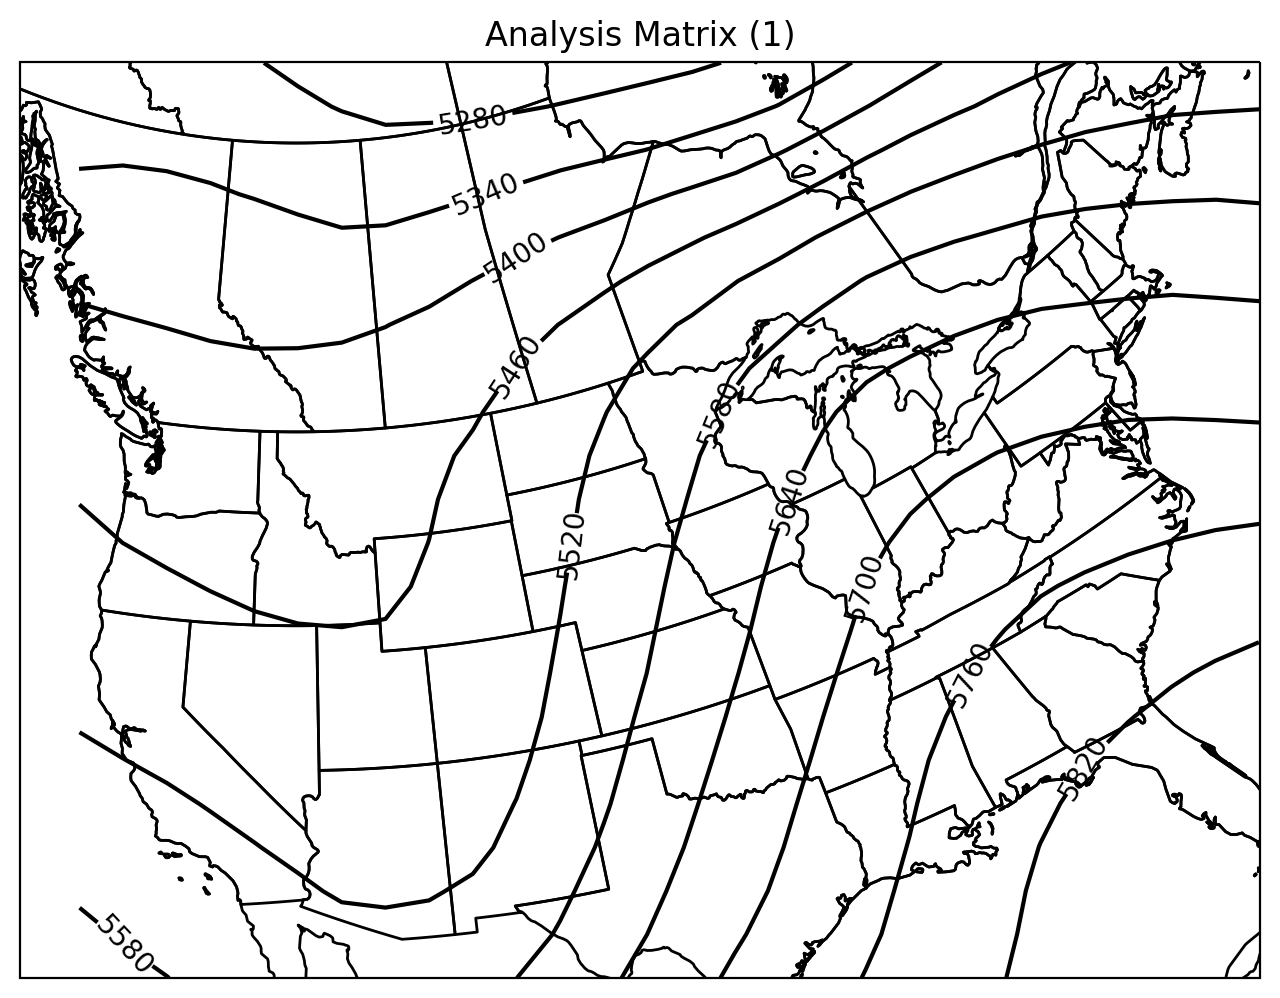

In [194]:
#Plotting the First Pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,Analysis_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())

plt.clabel(cs1,levels=np.arange(0,8000,60)) #Contour levels and intervals
plt.title("Analysis Matrix (1)")
#show plot
plt.show()

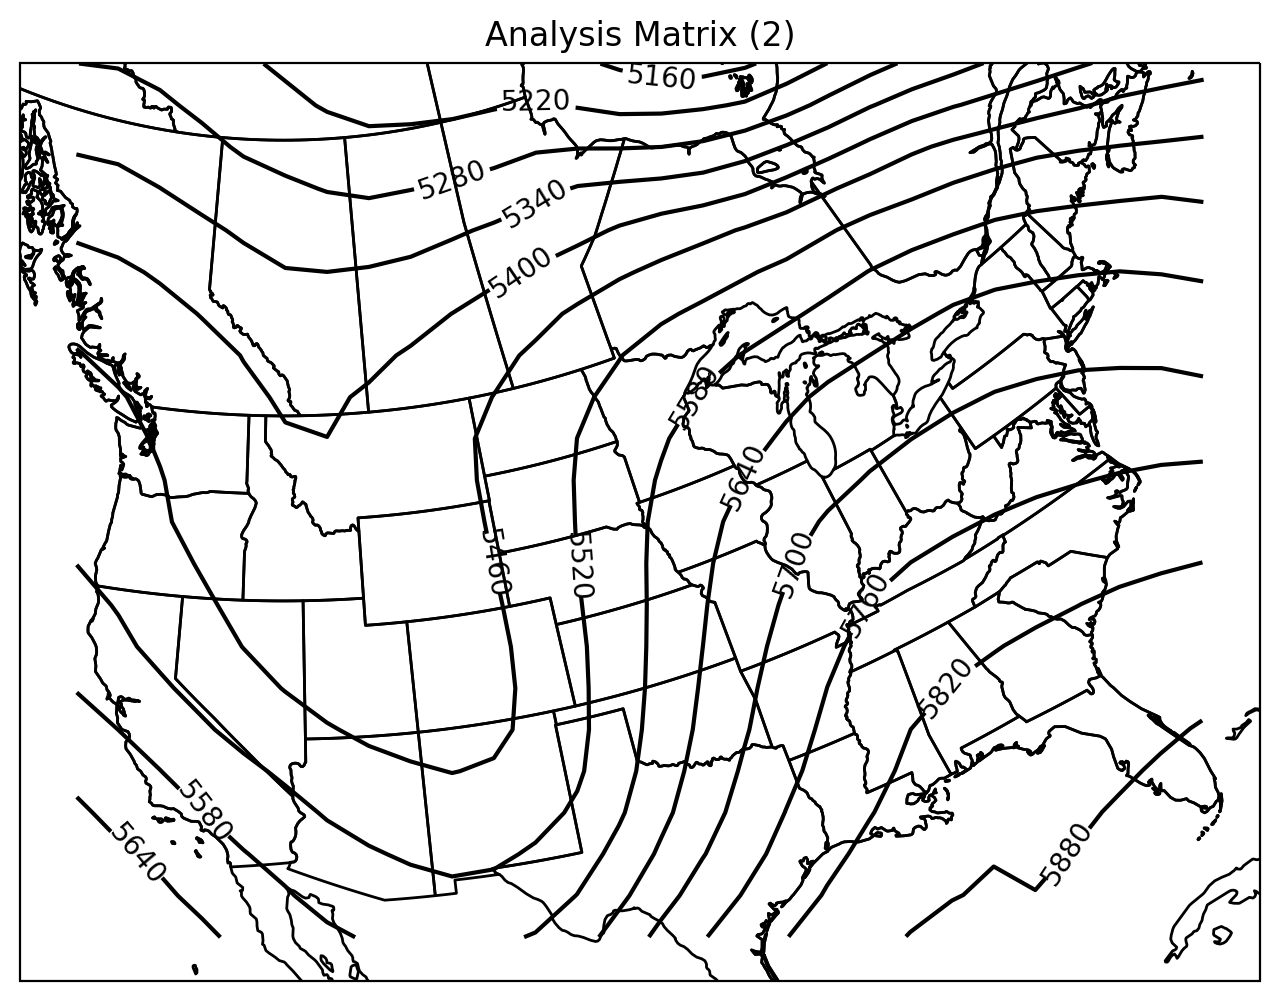

In [195]:
#Plotting the Second Pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,Analysis_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())

plt.clabel(cs1,levels=np.arange(0,8000,60)) #Contour levels and intervals
plt.title("Analysis Matrix (2)")
#show plot
plt.show()

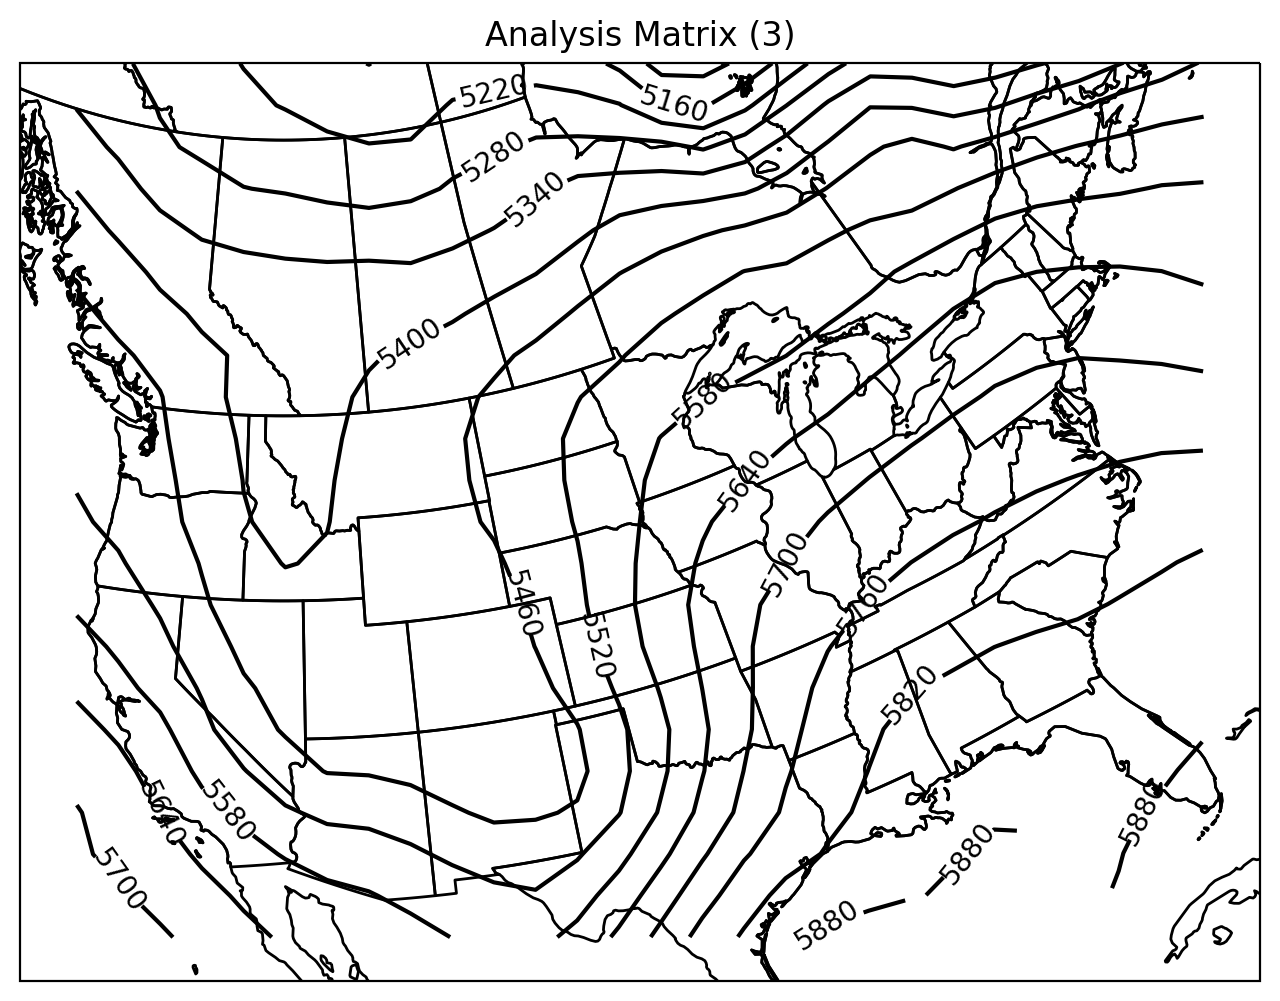

In [196]:
#Plotting the Third Pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon,lat,Analysis_mat[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())

plt.clabel(cs1,levels=np.arange(0,8000,60)) #Contour levels and intervals
plt.title("Analysis Matrix (3)")
#show plot
plt.show()

In [197]:
#Calculate ppp (3rd)
ppp = np.zeros(len(x_plane))
#a = analysis
for i in range(len(ind_x)):
    if (ind_x[i] >= 0 and ind_x[i] < 21) and (ind_y[i] >= 0 and ind_y[i] < 27): #if obs is inside the grid
        P = bilinear_interp(ind_x[i], ind_y[i], 2)
        
    else: #obs not in grid (reverse cressman)
        rel_xa = x_plane[i] - gridx
        rel_ya = y_plane[i] - gridy
        #calc radius
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) #calculate your radius from each grid point
        index_roi_a = np.where(radius_a <= ROIs[2]) #calc where your radius is less than or equal to your RoI
        #weights
        weights_a = np.zeros(gridx.shape)
        for j in index_roi_a[0]:
            for k in index_roi_a[1]:
                w_a = cressman(radius_a[j,k],ROIs[2])
                #print(w_a)
                weights_a[j,k] = w_a
        P = np.sum(weights_a * Analysis_mat[:,:,2]) / np.sum(weights_a)
    ppp[i] = P

Text(0.5, 1.0, 'Analysis Matrix (2) Minus Analysis Matrix (1)')

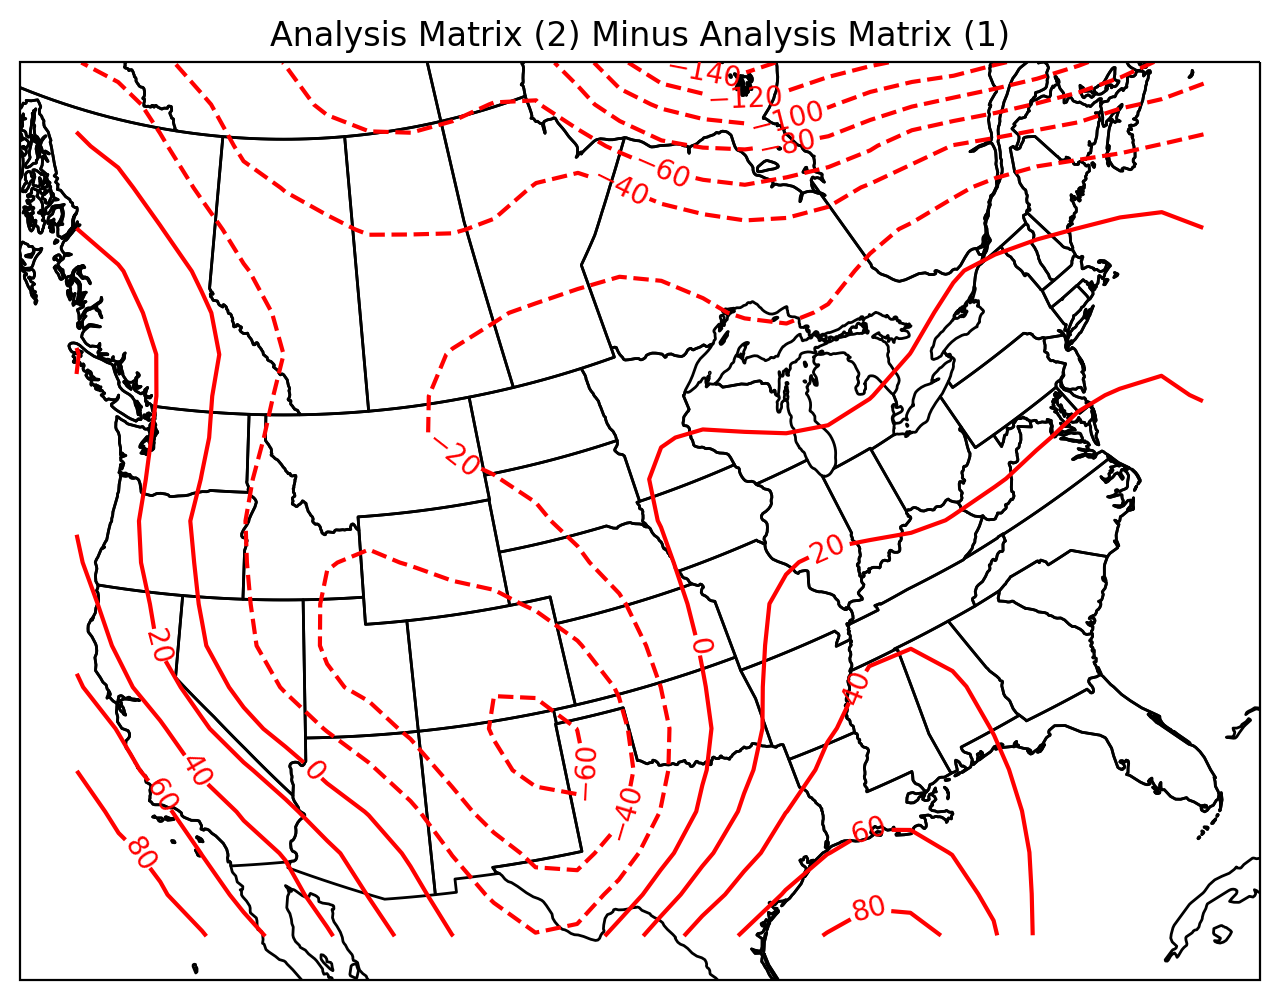

In [198]:
#Finding the Analysis matrix differences
#Analysis 2 - 1
Analysis_mat2_minus_A_M1 = Analysis_mat[:,:,1] - Analysis_mat[:,:,0]

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon, lat, Analysis_mat2_minus_A_M1[:,:], colors='r', levels = np.arange(-8000,8000,20), transform=ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(-8000,8000,20))
plt.title("Analysis Matrix (2) Minus Analysis Matrix (1)")

Text(0.5, 1.0, 'Analysis Matrix (3) Minus Analysis Matrix (1)')

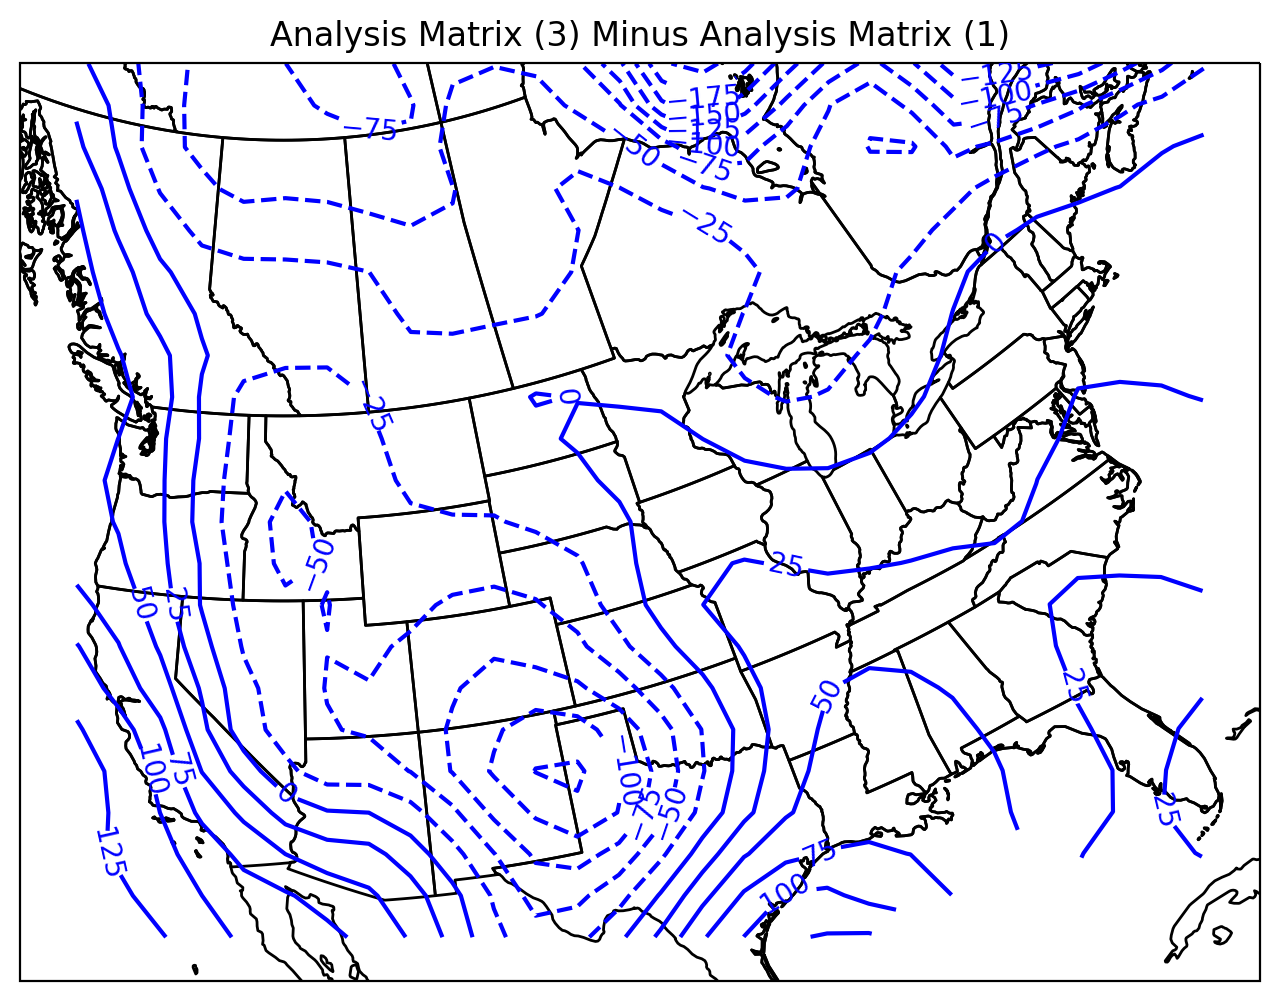

In [199]:
#Finding the Analysis matrix differences
#Analysis 3 - 1
Analysis_mat3_minus_A_M1 = Analysis_mat[:,:,2] - Analysis_mat[:,:,0]

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon, lat, Analysis_mat3_minus_A_M1[:,:], colors='b', levels = np.arange(-8000,8000,25), transform=ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(-8000,8000,25))
plt.title("Analysis Matrix (3) Minus Analysis Matrix (1)")

Text(0.5, 1.0, 'Analysis Matrix (3) Minus Analysis Matrix (2)')

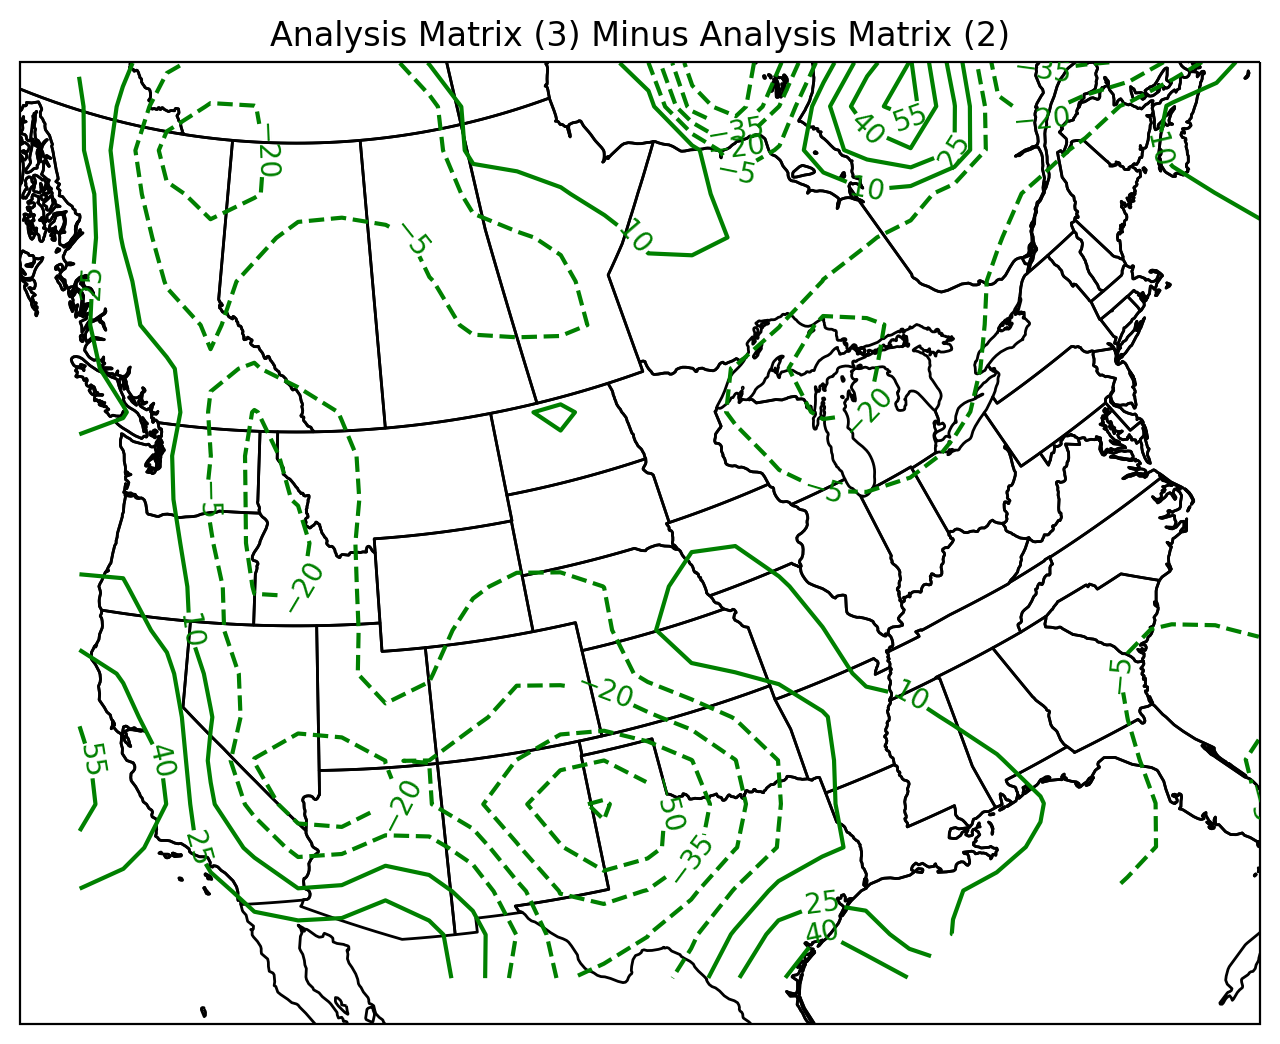

In [200]:
#Finding the Analysis matrix differences
#Analysis 3 - 2
Analysis_mat3_minus_A_M2 = Analysis_mat[:,:,2] - Analysis_mat[:,:,1]

### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lon, lat, Analysis_mat3_minus_A_M2[:,:], colors='g', levels = np.arange(-8000,8000,15), transform=ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(-8000,8000,15))
plt.title("Analysis Matrix (3) Minus Analysis Matrix (2)")

In [201]:
#Next, need to compute the root mean square differences (RMSD) between the analyses 
#and the observations for each pass.

#Equation:
#RMS = np.sqrt((sum((height - p or pp or ppp)^2)) / K)

#Analysis 1
diff1 = (height - p)**2
diff1 = diff1[~np.isnan(diff1)]
RMS1 = np.sqrt((np.sum(diff1))/len(diff1))

#Analysis 2
diff2 = (height - pp)**2
diff2 = diff2[~np.isnan(diff2)]
RMS2 = np.sqrt((np.sum(diff2))/len(diff2))

#Analysis 3
diff3 = (height - ppp)**2
diff3 = diff3[~np.isnan(diff3)]
RMS3 = np.sqrt((np.sum(diff3))/len(diff3))

RMS_lst = list([RMS1, RMS2, RMS3])

In [202]:
### Store the analyses in text files ###
np.savetxt('Analysis-Matrix_RoI_4_dmin.txt', Analysis_mat[:,:,0], delimiter=',') #Analysis Matrix RoI of 4 * dmin
np.savetxt('Analysis-Matrix_RoI_2.5_dmin.txt', Analysis_mat[:,:,1], delimiter=',') #Analysis Matrix RoI of 2.5 * dmin
np.savetxt('Analysis-Matrix_RoI_1.5_dmin.txt', Analysis_mat[:,:,2], delimiter=',') #Analysis Matrix RoI of 1.5 * dmin


In [203]:
### Store the difference fields in text files ###
np.savetxt('Analysis-Matrix_Diff_2-1.txt', Analysis_mat2_minus_A_M1, delimiter=',') #Analysis Matrix difference between AM2 and AM1
np.savetxt('Analysis-Matrix_Diff_3-1.txt', Analysis_mat3_minus_A_M1, delimiter=',') #Analysis Matrix difference between AM3 amd AM1
np.savetxt('Analysis-Matrix_Diff_3-2.txt', Analysis_mat3_minus_A_M2, delimiter=',') #Analysis Matrix difference between AM3 and AM2

In [204]:
### Store RMS values in text file ###
np.savetxt('RMS1-3.txt', RMS_lst, delimiter=',') #Root Mean Square Differences

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

ANSWER: In all of the contoured analyses plotted you can clearly see a upper-level trough over the 
        western CONUS digging into New Mexico and the Texas panhandle. Conversely, there is an upper-
        level ridge over the central and eastern CONUS.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?

ANSWER: Some main differences that I observed:
        1.) Going from the first pass to the third -> the height contours progressivly move south (look
        at the 5460 contour for example). Also, the contours become more compact (tighter hight gradient).
        2.) In the first pass there is no 5880 contour over the Gulf of Mexico and Florida, but in the 
        second and third passes there is.
        The first pass is definitly the smoothest out of all three contoured plots. Next is the second
        pass, then the third being the less smoothest out of the bunch. The difference between the plots is 
        mainly due to the difference in radius of influence. The higher your radius of influence, the larger 
        the area you are using for each grid point, and the more observation points you are including. Thus, 
        your analysis will be more smoother than if you used a smaller RoI.

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?

ANSWER: As your increase your number of successive correction passes as well as decrease your radius of influence
        with every pass the more you will resolve small scale features. This is good up until a certain number 
        of passes because you begin to desolve your larger scale features and your contours become become very
        rigid and contain more noise. This is not desirable at looking at synoptic features such as upper-level
        high and low pressure systems (larger wavelength systems).

'''